In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orangecontrib.associate.fpgrowth as oaf
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## 导入并检查数据

In [2]:
basket = pd.read_csv("Basket-2018-06-01-2018-07-05.csv")
item = pd.read_csv("item-2018-06-01-2018-07-05.csv")
basket.head()

,SHOP_DATETIME,STORE_CODE,POS_NO,BASK_CODE,BASK_SPEND
0,2018-06-01,D007,3,250458,8.0
1,2018-06-01,D007,3,250200,32.7
2,2018-06-01,D007,1,161068,16.8
3,2018-06-01,D007,8,5325,30.4
4,2018-06-01,D007,8,5361,191.3


In [3]:
basket.isnull().any()

SHOP_DATETIME    False
STORE_CODE       False
POS_NO           False
BASK_CODE        False
BASK_SPEND       False
dtype: bool

In [4]:
item.head()

,SDATE,STORE_CODE,POSID,BASK_CODE,PROD_CODE,ITEM_QUANTITY,ITEM_SPEND,NORMAL_PRICE,DISCOUNT_TYPE,DISCOUNT_AMOUNT
0,2018-06-01,D007,3,250451,29405,1.000,1.70,2.0,m,-0.3
1,2018-06-01,D007,3,250451,13187,1.000,1.00,1.0,n,0.0
2,2018-06-01,D007,3,250243,196249,1.000,99.00,99.0,m,0.0
3,2018-06-01,D007,3,250243,199637,1.000,9.90,16.8,p,-6.9
4,2018-06-01,D007,1,160905,195012,3.222,18.69,5.8,n,0.0


In [5]:
item.isnull().any()

SDATE              False
STORE_CODE         False
POSID              False
BASK_CODE          False
PROD_CODE          False
ITEM_QUANTITY      False
ITEM_SPEND         False
NORMAL_PRICE       False
DISCOUNT_TYPE      False
DISCOUNT_AMOUNT    False
dtype: bool

## 统计
### 统计每个商店在售商品的数量

In [6]:
store_goods = item.groupby(["STORE_CODE"])["PROD_CODE"].unique()
store_goods_num = pd.Series([len(d) for d in store_goods], index=store_goods.index)
store_goods_num

STORE_CODE
A001     7597
A004     3576
A006     4758
A007     4589
A008     5283
A009     4596
A010     4494
A012     4969
A013     5446
A016     4265
A017     3290
A018     4177
A019     3678
A021     4811
A022     4316
D002    10802
D003     2898
D004     4670
D005     4248
D006     5039
D007     6468
D008     4970
D009     4148
D010     3654
dtype: int64

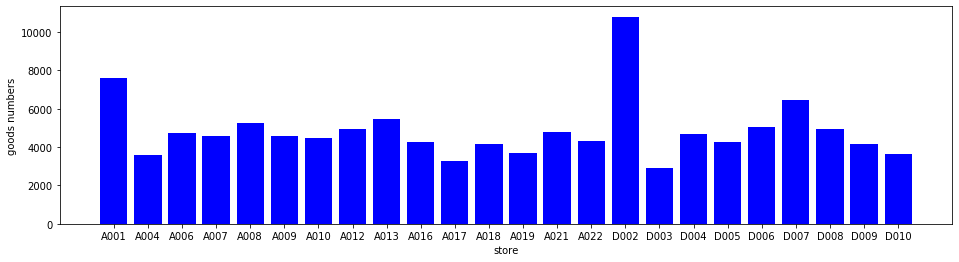

In [7]:
plt.figure(figsize=(16, 4))
plt.bar(store_goods_num.index, store_goods_num, width=0.8, fc="b")
plt.xlabel("store")
plt.ylabel("goods numbers")
plt.show()

### 统计每个商店的销售额

In [8]:
store_sales = item.groupby(["STORE_CODE"])["ITEM_SPEND"].sum()
store_sales

STORE_CODE
A001    3.435303e+06
A004    5.123467e+05
A006    9.383050e+05
A007    6.866382e+05
A008    1.311171e+06
A009    7.977389e+05
A010    6.448924e+05
A012    8.469747e+05
A013    1.117126e+06
A016    7.398143e+05
A017    3.945074e+05
A018    5.584417e+05
A019    6.486686e+05
A021    7.387401e+05
A022    4.874459e+05
D002    3.129447e+06
D003    2.435843e+05
D004    8.078603e+05
D005    5.541030e+05
D006    7.935042e+05
D007    1.361607e+06
D008    6.930078e+05
D009    4.704280e+05
D010    3.636179e+05
Name: ITEM_SPEND, dtype: float64

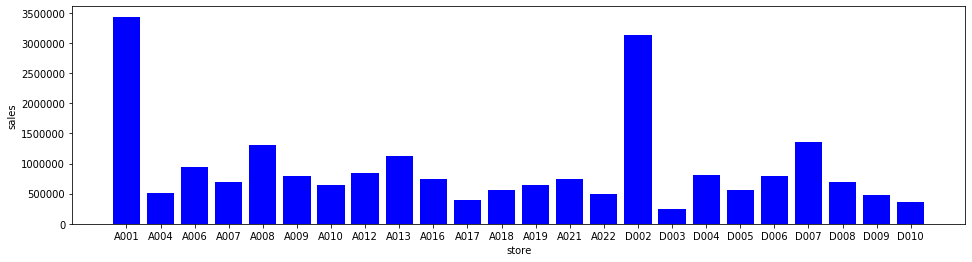

In [9]:
plt.figure(figsize=(16, 4))
plt.bar(store_sales.index, store_sales, fc="b")
plt.xlabel("store")
plt.ylabel("sales")
plt.show()

### 统计每种商品的销量

In [10]:
goods_sale_nums = item.groupby(["PROD_CODE"])["ITEM_QUANTITY"].sum()

#### 销售量前10的商品

In [11]:
sale_nums_top10 = goods_sale_nums.sort_values(ascending = False,inplace = False)[:10]
sale_nums_top10

PROD_CODE
149413    39823.000
86772     31252.000
220834    25644.000
7133      23015.000
61623     21756.000
124556    19887.000
205540    19302.000
1152      19135.000
194690    18101.534
124554    16641.000
Name: ITEM_QUANTITY, dtype: float64

### 统计每种商品的销售额

In [12]:
goods_sales = item.groupby(["PROD_CODE"])["ITEM_SPEND"].sum()

#### 销售额前10的商品

In [13]:
sales_top10 = goods_sales.sort_values(ascending = False,inplace = False)[:10]
sales_top10

PROD_CODE
7137      405757.50
7133      289616.00
136839    280198.10
149413    173332.43
1239      148703.20
154900    140534.90
220834    127344.90
21835     114438.46
88160     103116.80
3971       84488.00
Name: ITEM_SPEND, dtype: float64

### 统计每个商店的客单价

In [14]:
store_bask_spent = item.groupby(["STORE_CODE", "BASK_CODE"])["ITEM_SPEND"].sum()
store_index = store_bask_spent.index.levels[0]
store_atv = pd.Series([store_bask_spent[i].sum() / len(store_bask_spent[i]) for i in store_index],
                      index=store_index)
store_atv

STORE_CODE
A001    52.964078
A004    37.979738
A006    32.868777
A007    54.176910
A008    35.847850
A009    36.473065
A010    32.916109
A012    33.846494
A013    37.067041
A016    40.336638
A017    31.527804
A018    35.409403
A019    38.114376
A021    35.757024
A022    31.850883
D002    54.981674
D003    31.216753
D004    37.732847
D005    36.149723
D006    42.567686
D007    36.208126
D008    32.911040
D009    29.631391
D010    32.773129
dtype: float64

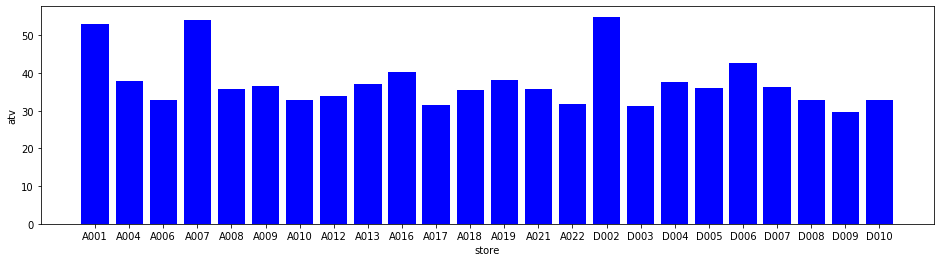

In [15]:
plt.figure(figsize=(16, 4))
plt.bar(store_atv.index, store_atv, fc="b")
plt.xlabel("store")
plt.ylabel("atv")
plt.show()

## 预测
### 根据A001前三天的销售额预测下一天的销售额

In [28]:
item_A001 = item[item["STORE_CODE"] == "A001"]
item_A001.head(10)

,SDATE,STORE_CODE,POSID,BASK_CODE,PROD_CODE,ITEM_QUANTITY,ITEM_SPEND,NORMAL_PRICE,DISCOUNT_TYPE,DISCOUNT_AMOUNT
808,2018-06-02,A001,6,229611,15930,1.0,1.8,1.800000,n,0.0
809,2018-06-02,A001,6,229611,15930,1.0,1.8,1.800000,n,0.0
810,2018-06-02,A001,2,125591,147631,12.0,55.0,4.583333,n,0.0
811,2018-06-02,A001,6,229732,157209,1.0,7.5,7.500000,n,0.0
812,2018-06-02,A001,6,229733,148937,1.0,2.5,2.500000,n,0.0
813,2018-06-02,A001,6,229611,15930,1.0,1.8,1.800000,n,0.0
814,2018-06-02,A001,6,229611,2694,1.0,1.5,1.500000,n,0.0
815,2018-06-02,A001,6,229611,2694,1.0,1.5,1.500000,n,0.0
816,2018-06-02,A001,6,229611,180395,1.0,21.5,21.500000,n,0.0
817,2018-06-02,A001,9,267191,151684,1.0,108.0,108.000000,n,0.0


In [26]:
sales_A001 = item_A001.groupby(["SDATE"])["ITEM_SPEND"].sum()
sales_A001

SDATE
2018-06-01    101971.08
2018-06-02     78829.76
2018-06-03     79162.82
2018-06-04     53990.84
2018-06-05     81708.30
2018-06-06     79167.81
2018-06-07     59450.59
2018-06-08     65490.97
2018-06-09    128980.30
2018-06-10     95312.58
2018-06-11     79403.76
2018-06-12    104093.21
2018-06-13    123849.34
2018-06-14     94912.87
2018-06-15    139586.92
2018-06-16    312102.30
2018-06-17    324323.29
2018-06-18    204457.64
2018-06-19     53757.07
2018-06-20     85382.17
2018-06-21     67307.82
2018-06-22     60339.19
2018-06-23     80734.51
2018-06-24     75519.24
2018-06-25     64212.92
2018-06-26     68054.72
2018-06-27     72622.72
2018-06-28     55328.60
2018-06-29     80056.55
2018-06-30     96779.60
2018-07-01     87396.05
2018-07-02     69952.23
2018-07-03     73419.27
2018-07-04     73999.72
2018-07-05     63646.30
Name: ITEM_SPEND, dtype: float64

In [44]:
x = []
y = []
for i in range(len(sales_A001) - 3):
    x.append(list(sales_A001[i:i+3]))
    y.append(sales_A001[i+3])
x = np.array(x)
y = np.array(y)
x, y    

(array([[101971.08      ,  78829.76      ,  79162.82      ],
        [ 78829.76      ,  79162.82      ,  53990.84      ],
        [ 79162.82      ,  53990.84      ,  81708.3       ],
        [ 53990.84      ,  81708.3       ,  79167.81      ],
        [ 81708.3       ,  79167.81      ,  59450.59      ],
        [ 79167.81      ,  59450.59      ,  65490.97      ],
        [ 59450.59      ,  65490.97      , 128980.3       ],
        [ 65490.97      , 128980.3       ,  95312.58      ],
        [128980.3       ,  95312.58      ,  79403.76      ],
        [ 95312.58      ,  79403.76      , 104093.21      ],
        [ 79403.76      , 104093.21      , 123849.34      ],
        [104093.21      , 123849.34      ,  94912.87      ],
        [123849.34      ,  94912.87      , 139586.92      ],
        [ 94912.87      , 139586.92      , 312102.3       ],
        [139586.92      , 312102.3       , 324323.29      ],
        [312102.3       , 324323.29      , 204457.63999999],
        [324323.29      

In [45]:
train_x, train_y = x[:20], y[:20]
test_x, test_y = x[20:], y[20:]

In [54]:
reg = linear_model.LinearRegression()
reg.fit(train_x, train_y)
linear_predict_y = reg.predict(test_x)
linear_predict_y

array([105475.29492327,  84686.24580801,  80406.30256398,  91053.29289874,
        90971.90267845,  70252.33932454, 109244.73353267, 106761.93309328,
        90612.83181249,  81842.07172623,  95367.77197168,  90010.88931279])

In [56]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(train_x, train_y)
lasso_predict_y = lasso.predict(test_x)
lasso_predict_y

array([105475.29492345,  84686.2458123 ,  80406.30256663,  91053.2928999 ,
        90971.90268082,  70252.33932885, 109244.73353169, 106761.93309591,
        90612.83181603,  81842.07172848,  95367.771972  ,  90010.88931524])

In [53]:
mse_linear = mean_squared_error(test_y, linear_predict_y)
mse_lasso = mean_squared_error(test_y, linear_predict_y)

(446270310.92116874, -2.999946195698173)

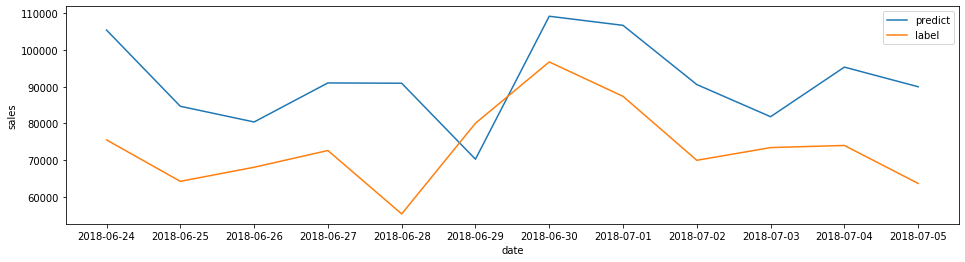

In [48]:
plt.figure(figsize=(16, 4))
plt.plot(sales_A001.index[23:], predict_y, label="predict")
plt.plot(sales_A001.index[23:], test_y, label="label")
plt.legend()
plt.xlabel("date")
plt.ylabel("sales")
plt.show()

## 关联分析

In [16]:
basket_data = []
for bask_code, group in item[["BASK_CODE", "PROD_CODE"]].groupby("BASK_CODE"):
     basket_data.append(list(group["PROD_CODE"]))
basket_data

[[7137],
 [7133, 95809],
 [3968, 3968],
 [19319, 19319],
 [7133],
 [3968],
 [155493, 14318, 14318, 95808, 95808],
 [196139],
 [205524],
 [15611],
 [1239],
 [314, 167936],
 [19319],
 [106, 156350, 156350, 1026, 5694, 29360, 150195, 179045, 209929],
 [219934, 6797],
 [14318],
 [198097],
 [130163, 1801, 173353, 2740, 71433, 219118],
 [7137],
 [1148],
 [196127],
 [207086],
 [128326, 3297],
 [169428, 223640, 220574, 183725],
 [119597, 108194],
 [85285, 223779, 109584, 109584],
 [109584, 109584, 191955, 85366, 85366],
 [109584, 196250, 109584, 72811],
 [108091],
 [208390, 208379],
 [204795],
 [204999],
 [4650, 4650],
 [136839],
 [200924, 58443, 58442, 21279, 21286],
 [7133, 194103, 10270],
 [131561, 205540, 175996, 205540, 1052, 131561],
 [211614],
 [10339],
 [101423, 101423, 106883, 4604],
 [224012, 96008, 20011, 224011, 96008, 196895, 5210, 5445],
 [129449],
 [106652, 106652, 196361, 7893, 129449],
 [106652, 7893, 7893, 645, 195986],
 [106883],
 [4650, 174621],
 [12477, 313, 62547],
 [3040

In [35]:
item_sets = dict(oaf.frequent_itemsets(basket_data, 500))
item_sets

{frozenset({205540}): 8284,
 frozenset({21835}): 10138,
 frozenset({194690}): 9046,
 frozenset({21835, 194690}): 762,
 frozenset({72811}): 7462,
 frozenset({21835, 72811}): 1048,
 frozenset({72811, 194690}): 672,
 frozenset({178462}): 4248,
 frozenset({197532}): 6348,
 frozenset({205437}): 5883,
 frozenset({1557}): 5505,
 frozenset({109584}): 3952,
 frozenset({216571}): 5043,
 frozenset({198366}): 4826,
 frozenset({75283}): 5045,
 frozenset({3096}): 4736,
 frozenset({124556}): 4142,
 frozenset({3046}): 4003,
 frozenset({219118}): 4602,
 frozenset({191955}): 3877,
 frozenset({124554}): 3697,
 frozenset({124554, 124556}): 1445,
 frozenset({7133}): 3916,
 frozenset({196250}): 4148,
 frozenset({125140}): 3564,
 frozenset({124554, 125140}): 1408,
 frozenset({124556, 125140}): 1703,
 frozenset({124554, 124556, 125140}): 820,
 frozenset({157970}): 3479,
 frozenset({107293}): 4347,
 frozenset({21835, 107293}): 930,
 frozenset({72811, 107293}): 545,
 frozenset({217998}): 2433,
 frozenset({20708

In [37]:
rules = oaf.association_rules(item_sets, .5)
rules = list(rules)
rules

[(frozenset({124554, 125140}), frozenset({124556}), 820, 0.5823863636363636),
 (frozenset({124554, 124556}), frozenset({125140}), 820, 0.5674740484429066),
 (frozenset({4190, 124554}), frozenset({124556}), 685, 0.552865213882163),
 (frozenset({4190, 124554}), frozenset({125140}), 685, 0.552865213882163),
 (frozenset({4190, 125140}), frozenset({124556}), 833, 0.5933048433048433),
 (frozenset({4190, 124556}), frozenset({125140}), 833, 0.573296627666896),
 (frozenset({4190, 124560}), frozenset({124556}), 565, 0.5300187617260788),
 (frozenset({124556, 124560}), frozenset({4190}), 565, 0.5131698455949137),
 (frozenset({4190, 124560}), frozenset({125140}), 580, 0.5440900562851783),
 (frozenset({124560, 125140}), frozenset({4190}), 580, 0.5582290664100096),
 (frozenset({124560, 125140}), frozenset({124556}), 602, 0.5794032723772858),
 (frozenset({124556, 124560}), frozenset({125140}), 602, 0.5467756584922797),
 (frozenset({4190, 124555}), frozenset({124554}), 509, 0.5009842519685039),
 (froze

In [38]:
result = list(oaf.rules_stats(rules, item_sets, len(basket_data)))
result

[(frozenset({124554, 125140}),
  frozenset({124556}),
  820,
  0.5823863636363636,
  0.005006916514645587,
  2.9417613636363638,
  39.53970345353584,
  0.0028422122598203412),
 (frozenset({124554, 124556}),
  frozenset({125140}),
  820,
  0.5674740484429066,
  0.005138490315101472,
  2.4664359861591696,
  44.775517574825535,
  0.0028508359221971345),
 (frozenset({4190, 124554}),
  frozenset({124556}),
  685,
  0.552865213882163,
  0.004405944290941677,
  3.343018563357546,
  37.53543690512239,
  0.002370997502753874),
 (frozenset({4190, 124554}),
  frozenset({125140}),
  685,
  0.552865213882163,
  0.004405944290941677,
  2.876513317191283,
  43.62283379938747,
  0.002380053463581026),
 (frozenset({4190, 125140}),
  frozenset({124556}),
  833,
  0.5933048433048433,
  0.0049926923200017065,
  2.95014245014245,
  40.28098703297883,
  0.0028886504027600375),
 (frozenset({4190, 124556}),
  frozenset({125140}),
  833,
  0.573296627666896,
  0.005166938704389231,
  2.452856159669649,
  45.23